In [2]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Research Agent 

*The goal of research is to gather the context requested by the research brief.*

Here is our overall research flow:

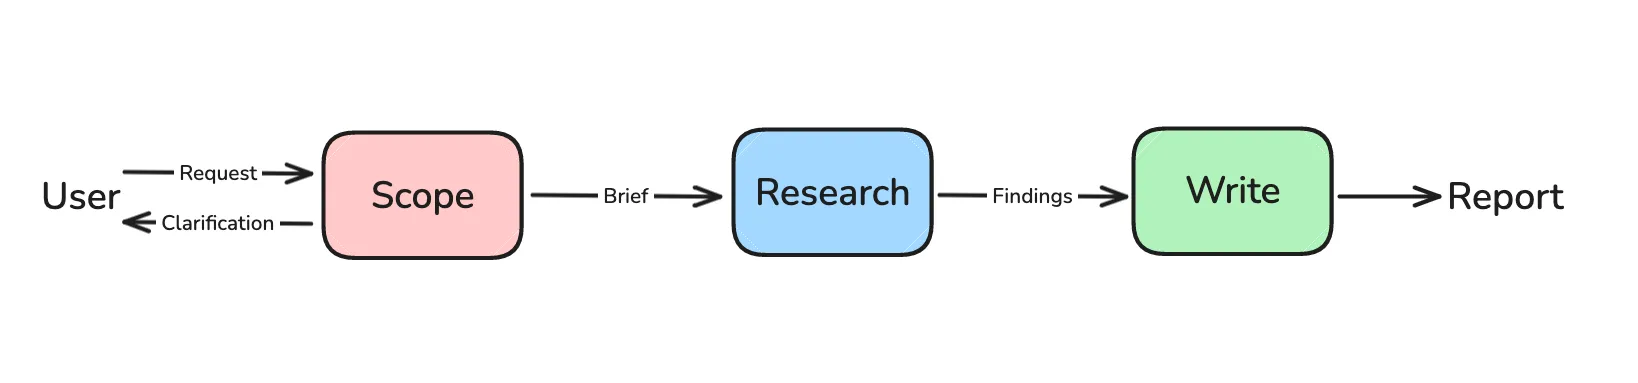

Research is an open‑ended task. The best strategy to answer a user request can't be easily known in advance. 

Requests can require different research strategies and varying levels of search depth. Consider this request:

> *"Compare these two products"*

Comparisons typically benefit from search on each product, followed by a synthesis step to compare them. Now, consider this one:

> *"Give me the top candidates for my job posting"*

Listing and ranking requests typically require open-ended search, followed by a synthesis and ranking.
 
[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) are well suited to research because they can flexibly apply different strategies, using intermediate results to guide their exploration.

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

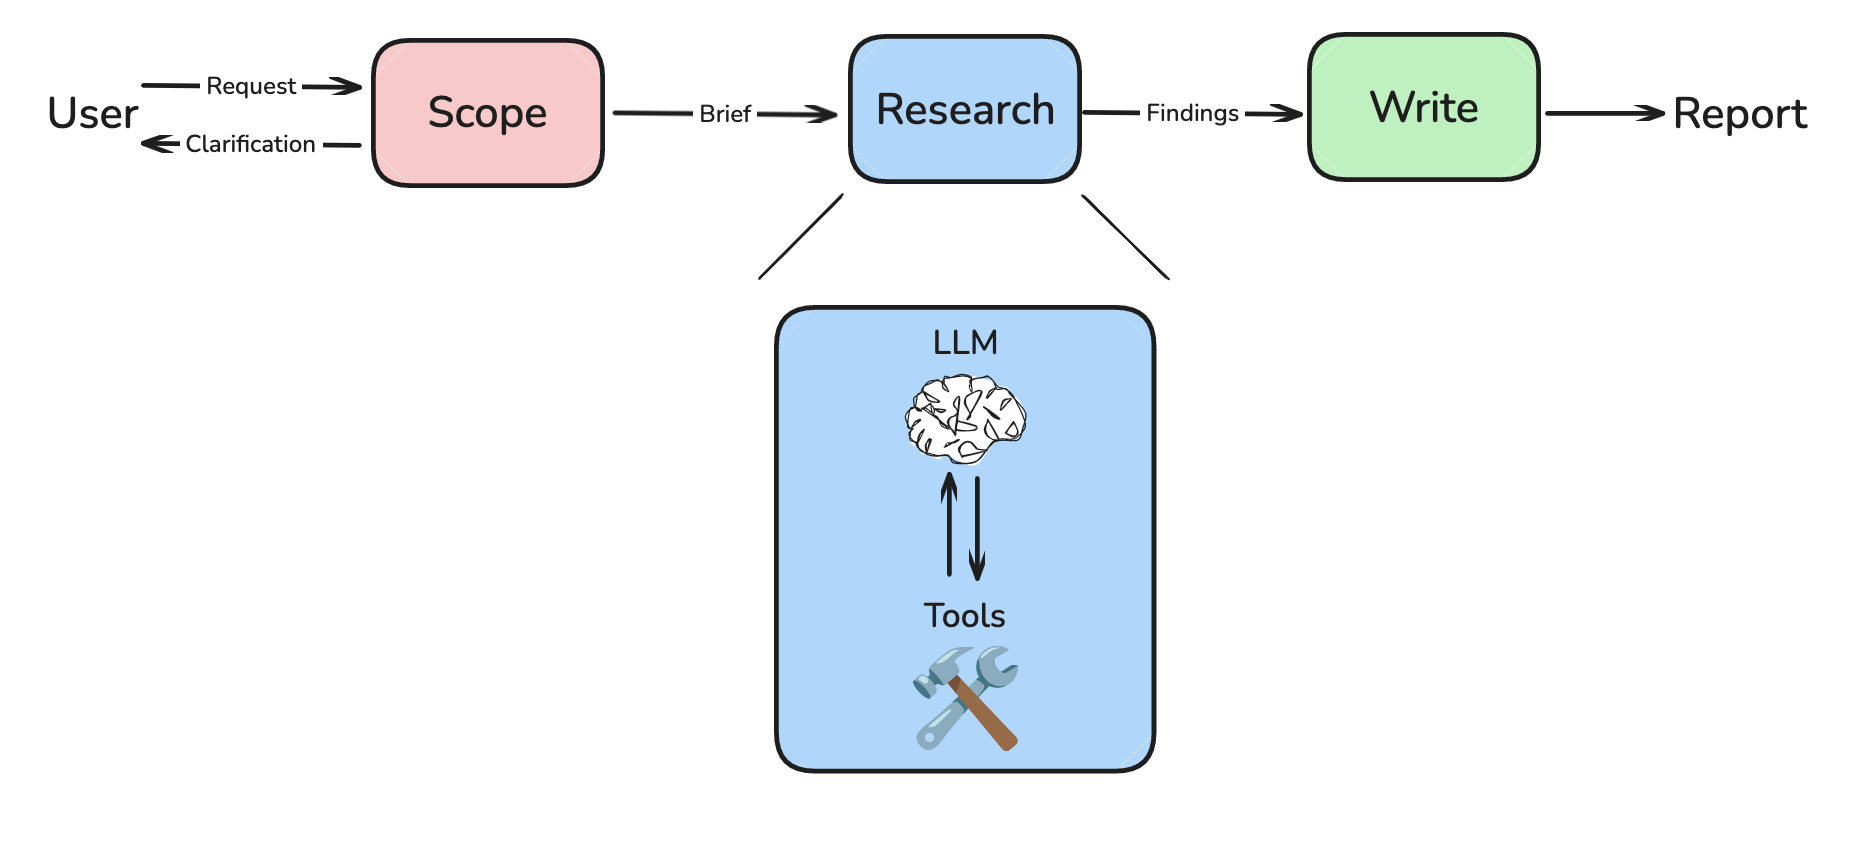

### Prompt

First, we'll define a prompt that instructs our agent to use available search tools. 

To prevent excessive tool calls and maintain research focus, we use [a few prompting techniques for agents](https://youtu.be/XSZP9GhhuAc?si=zowpViL-2j-vI9hA):

#### 1. Think Like The Agent
What instructions would you give a new work colleague?
- **Read the question carefully** - What specific information does the user need?
- **Start with broader searches** - Use broad, comprehensive queries first
- **After each search, pause and assess** - Do I have enough to answer? What's still missing?
- **Execute narrower searches as you gather information** - Fill in the gaps.

#### 2. Concrete Heuristics (Prevent "Spin-Out" on excessive tool calls)
Use **Hard Limits** to prevent the research agent from calling tools excessively:
- **Stop when you can answer confidently** - Don't keep searching for perfection.
- **Give it budgets** - Use 2-3 search tool calls for simple queries. Use up to 5 for complex queries.
- **Limit** - Always stop after 5 search tool calls if you cannot find the right source(s).

#### 3. Show your thinking
After each search tool calling, use [`think_tool` to analyze the results](https://www.anthropic.com/engineering/claude-think-tool):
- What key information did I find? 
- What's missing?
- Do I have enough to answer the question comprehensively?
- Should I search more or provide my answer?

#### Results
These techniques transform problematic research behavior like:
```
"best coffee shops SF" → "Saint Frank Coffee details" → "Sightglass Coffee details" → "Ritual Coffee details" → etc. (20+ searches)
```

Into efficient patterns like:
```
"best coffee shops SF" → ThinkTool(analyze results) → "SF specialty coffee quality ratings" → ThinkTool(assess completeness) → provide answer (3-5 searches total)
```

The key insight: **Think like a human researcher with limited time** - this prevents the "spin-out problem" where agents continue searching indefinitely.

In [2]:
from utils import show_prompt
from deep_research_from_scratch.prompts import research_agent_prompt
show_prompt(research_agent_prompt, "Research Agent Instructions")

╭────────────────────────────────────────── Research Agent Instructions ──────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Complex queries**: Use up to 5 search tool calls maximum                                                   │
│  - **Always stop**: After 5 search tool calls if you cannot find the right sources                              │
│                                                       

### State and Schemas

We'll create the agent state object.


In [4]:
%%writefile ../src/deep_research_from_scratch/state_research.py

"""
State Definitions and Pydantic Schemas for Research Agent

This module defines the state objects and structured schemas used for
the research agent workflow, including researcher state management and output schemas.
"""

import operator
from typing_extensions import TypedDict, Annotated, List, Sequence
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# ===== STATE DEFINITIONS =====

class ResearcherState(TypedDict):
    """
    State for the research agent containing message history and research metadata.
    
    This state tracks the researcher's conversation, iteration count for limiting
    tool calls, the research topic being investigated, compressed findings,
    and raw research notes for detailed analysis.
    """
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    tool_call_iterations: int
    research_topic: str
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]

class ResearcherOutputState(TypedDict):
    """
    Output state for the research agent containing final research results.
    
    This represents the final output of the research process with compressed
    research findings and all raw notes from the research process.
    """
    compressed_research: str
    raw_notes: Annotated[List[str], operator.add]
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

# ===== STRUCTURED OUTPUT SCHEMAS =====

class ClarifyWithUser(BaseModel):
    """Schema for user clarification decisions during scoping phase."""
    need_clarification: bool = Field(
        description="Whether the user needs to be asked a clarifying question.",
    )
    question: str = Field(
        description="A question to ask the user to clarify the report scope",
    )
    verification: str = Field(
        description="Verify message that we will start research after the user has provided the necessary information.",
    )

class ResearchQuestion(BaseModel):
    """Schema for research brief generation."""
    research_brief: str = Field(
        description="A research question that will be used to guide the research.",
    )

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    summary: str = Field(description="Concise summary of the webpage content")
    key_excerpts: str = Field(description="Important quotes and excerpts from the content")

Overwriting ../src/deep_research_from_scratch/state_research.py


Now, we'll define our research tool.  

#### Tavily SDK Integration

We'll use the [Tavily SDK](https://docs.tavily.com/sdk/python/reference) to perform web searches.
 
Tavily is a search engine optimized for AI applications with a generous free tier, providing:
- Real-time web search results
- Content extraction and summarization
- Domain filtering and result ranking
- Async support for performance

#### Alternative Web Content Sources

While we use Tavily's search API in this tutorial, there are several other excellent options for web content extraction:

- **[Tavily Extract](https://docs.tavily.com/documentation/api-reference/endpoint/extract)**: Tavily's dedicated content extraction endpoint that can extract and clean content from specific URLs without performing searches
- **[Jina Reader](https://jina.ai/reader/)**: A powerful web content extraction service that converts web pages to clean, LLM-friendly text by simply prepending `https://r.jina.ai/` to any URL
- **[Firecrawl](https://www.firecrawl.dev/)**: A comprehensive web scraping platform that converts websites into clean markdown or structured data, with advanced features like JavaScript rendering and sitemap crawling

Each tool has different strengths: Tavily excels at search-first workflows, Jina Reader offers the simplest URL-to-text conversion, and Firecrawl provides the most comprehensive web scraping capabilities for complex sites.

####  LangChain Tools

We'll convert our Tavily search function into a [LangChain tool](https://python.langchain.com/docs/concepts/tools/) using the `@tool` decorator. This enables:
- Automatic schema generation for the LLM
- Integration with LangChain's agent framework
- Standardized tool calling interface
- Type validation and documentation

Note that some of the arguments are noted as [InjectedToolArg](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.base.InjectedToolArg.html). These are not included in the tool schema sent to the LLM, and instead are injected during execution. This gives us the flexibility to inject values at runtime, but does not burden the language model with the responsibility of managing these arguments.

In [8]:
%%writefile ../src/deep_research_from_scratch/utils.py

"""Research Utilities and Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""

from pathlib import Path
from datetime import datetime
from typing_extensions import Annotated, List, Literal

from langchain.chat_models import init_chat_model 
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, InjectedToolArg
from tavily import TavilyClient

from deep_research_from_scratch.state_research import Summary
from deep_research_from_scratch.prompts import summarize_webpage_prompt

# ===== UTILITY FUNCTIONS =====

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def get_current_dir() -> Path:
    """Get the current directory of the module.

    This function is compatible with Jupyter notebooks and regular Python scripts.

    Returns:
        Path object representing the current directory
    """
    try:
        return Path(__file__).resolve().parent
    except NameError:  # __file__ is not defined
        return Path.cwd()

# ===== CONFIGURATION =====

summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
tavily_client = TavilyClient()

# ===== SEARCH FUNCTIONS =====

def tavily_search_multiple(
    search_queries: List[str], 
    max_results: int = 3, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> List[dict]:
    """Perform search using Tavily API for multiple queries.

    Args:
        search_queries: List of search queries to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        List of search result dictionaries
    """
    
    # Execute searches sequentially. Note: yon can use AsyncTavilyClient to parallelize this step.
    search_docs = []
    for query in search_queries:
        result = tavily_client.search(
            query,
            max_results=max_results,
            include_raw_content=include_raw_content,
            topic=topic
        )
        search_docs.append(result)

    return search_docs

def summarize_webpage_content(webpage_content: str) -> str:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Formatted summary with key excerpts
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary = structured_model.invoke([
            HumanMessage(content=summarize_webpage_prompt.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        # Format summary with clear structure
        formatted_summary = (
            f"<summary>\n{summary.summary}\n</summary>\n\n"
            f"<key_excerpts>\n{summary.key_excerpts}\n</key_excerpts>"
        )
        
        return formatted_summary
        
    except Exception as e:
        print(f"Failed to summarize webpage: {str(e)}")
        return webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content

def deduplicate_search_results(search_results: List[dict]) -> dict:
    """Deduplicate search results by URL to avoid processing duplicate content.
    
    Args:
        search_results: List of search result dictionaries
        
    Returns:
        Dictionary mapping URLs to unique results
    """
    unique_results = {}
    
    for response in search_results:
        for result in response['results']:
            url = result['url']
            if url not in unique_results:
                unique_results[url] = result
    
    return unique_results

def process_search_results(unique_results: dict) -> dict:
    """Process search results by summarizing content where available.
    
    Args:
        unique_results: Dictionary of unique search results
        
    Returns:
        Dictionary of processed results with summaries
    """
    summarized_results = {}
    
    for url, result in unique_results.items():
        # Use existing content if no raw content for summarization
        if not result.get("raw_content"):
            content = result['content']
        else:
            # Summarize raw content for better processing
            content = summarize_webpage_content(result['raw_content'])
        
        summarized_results[url] = {
            'title': result['title'],
            'content': content
        }
    
    return summarized_results

def format_search_output(summarized_results: dict) -> str:
    """Format search results into a well-structured string output.
    
    Args:
        summarized_results: Dictionary of processed search results
        
    Returns:
        Formatted string of search results with clear source separation
    """
    if not summarized_results:
        return "No valid search results found. Please try different search queries or use a different search API."
    
    formatted_output = "Search results: \n\n"
    
    for i, (url, result) in enumerate(summarized_results.items(), 1):
        formatted_output += f"\n\n--- SOURCE {i}: {result['title']} ---\n"
        formatted_output += f"URL: {url}\n\n"
        formatted_output += f"SUMMARY:\n{result['content']}\n\n"
        formatted_output += "-" * 80 + "\n"
    
    return formatted_output

# ===== RESEARCH TOOLS =====

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    max_results: Annotated[int, InjectedToolArg] = 3,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> str:
    """Fetch results from Tavily search API with content summarization.

    Args:
        query: A single search query to execute
        max_results: Maximum number of results to return
        topic: Topic to filter results by ('general', 'news', 'finance')

    Returns:
        Formatted string of search results with summaries
    """
    # Execute search for single query
    search_results = tavily_search_multiple(
        [query],  # Convert single query to list for the internal function
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    )

    # Deduplicate results by URL to avoid processing duplicate content
    unique_results = deduplicate_search_results(search_results)

    # Process results with summarization
    summarized_results = process_search_results(unique_results)

    # Format output for consumption
    return format_search_output(summarized_results)

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    
    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?
    
    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_research_from_scratch/utils.py


### Research Agent

#### Overview

Our research agent perform iterative tool-calling to search for information. 

The agent follows a [simple yet effective pattern](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent):

1. **LLM Decision Node**: Analyzes the current state and decides whether to make tool calls or provide a final response
2. **Tool Execution Node**: Executes search tools when the LLM determines more information is needed
3. **Research Compression Node**: Summarizes and compresses research findings for efficient processing
4. **Routing Logic**: Determines workflow continuation based on LLM decisions

#### Context Engineering Strategy

We apply **context engineering** in two places following the principles outlined in [Context Engineering for Agents](https://blog.langchain.com/context-engineering-for-agents/):

#### 1. Webpage Content Summarization
Raw search results often contain excessive noise (navigation, ads, boilerplate content). Our `summarize_webpage_content()` function:
- Uses structured output to extract key information and relevant excerpts
- Filters out irrelevant content while preserving factual details
- Compresses lengthy articles into focused summaries
- Maintains source attribution for credibility

#### 2. Research Result Compression  
As the agent performs multiple searches, the conversation context grows rapidly. Our `compress_research()` function:
- Synthesizes findings from multiple tool calls into cohesive insights
- Extracts raw notes for detailed analysis while maintaining compressed summaries
- Reduces token usage for subsequent LLM calls
- Preserves essential information for report writing

This dual-layer context engineering allows the agent to process extensive information efficiently while maintaining high-quality research output.

#### 3. Performing Careful Compression
[Compression](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) [is risky](https://cognition.ai/blog/dont-build-multi-agents)! We need to be very careful about loosing valuable information. We'll use an LLM for compression with instructions in a system prompt that comes before a potentially long, token-heavy trajectory of multiple tool calls. The long context can cause the compression LLM [to loose sight of the task instructions](https://www.dbreunig.com/2025/06/22/how-contexts-fail-and-how-to-fix-them.html), leading to generic summaries that loose information. So, we reinforce the compression task by adding a `compress_research_human_message` that:
- Explicitly restates the original research topic at compression time
- Reminds the model to preserve ALL information relevant to the specific question
- Emphasizes that comprehensive findings are critical for final report generation
- Prevents task drift during the compression phase

#### 4. Output Token Management
Research compression can generate long outputs. We need to sure that they do not exceed model token limits, which can cause truncated responses that cut off mid-sentence (as seen with "**Sextant Coffee Ro" being cut off). As an example, [GPT-4.1 has output limit of up to 33k tokens](https://openai.com/index/gpt-4-1/) and [Claude4 sonnet supports 64k](https://www.anthropic.com/claude/sonnet). 

Model SDKs / LangChain integrations may cap this (e.g., [to `1024` tokens in the case of Claude](https://github.com/langchain-ai/langchain/blob/master/libs/partners/anthropic/langchain_anthropic/chat_models.py#L1149C5-L1149C15)). Simply ensure that max tokens is set to ensure complete output. This prevents incomplete compression outputs and ensures full research findings are preserved. Test compression quality vs latency for different models. For example: 

* Claude4-Sonnet 99s latency for compression ([trace](https://smith.langchain.com/public/ca006e79-8838-47eb-9d8c-c7fe7d57a6bc/r))
* GPT-4.1 38s latency for compression ([trace](https://smith.langchain.com/public/ca846b08-7501-43a0-bbda-735d4b07ab0a/r))

In [3]:
%%writefile ../src/deep_research_from_scratch/research_agent.py

"""Research Agent Implementation.

This module implements a research agent that can perform iterative web searches
and synthesis to answer complex research questions.
"""

from pydantic import BaseModel, Field
from typing_extensions import Literal

from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, filter_messages
from langchain.chat_models import init_chat_model

from deep_research_from_scratch.state_research import ResearcherState, ResearcherOutputState
from deep_research_from_scratch.utils import tavily_search, get_today_str, think_tool
from deep_research_from_scratch.prompts import research_agent_prompt, compress_research_system_prompt, compress_research_human_message

# ===== CONFIGURATION =====

# Set up tools and model binding
tools = [tavily_search, think_tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize models
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514")
model_with_tools = model.bind_tools(tools)
summarization_model = init_chat_model(model="openai:gpt-4.1-mini")
compress_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== AGENT NODES =====

def llm_call(state: ResearcherState):
    """Analyze current state and decide on next actions.
    
    The model analyzes the current conversation state and decides whether to:
    1. Call search tools to gather more information
    2. Provide a final answer based on gathered information
    
    Returns updated state with the model's response.
    """
    return {
        "researcher_messages": [
            model_with_tools.invoke(
                [SystemMessage(content=research_agent_prompt)] + state["researcher_messages"]
            )
        ]
    }

def tool_node(state: ResearcherState):
    """Execute all tool calls from the previous LLM response.
    
    Executes all tool calls from the previous LLM responses.
    Returns updated state with tool execution results.
    """
    tool_calls = state["researcher_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"researcher_messages": tool_outputs}

def compress_research(state: ResearcherState) -> dict:
    """Compress research findings into a concise summary.
    
    Takes all the research messages and tool outputs and creates
    a compressed summary suitable for the supervisor's decision-making.
    """
    
    system_message = compress_research_system_prompt.format(date=get_today_str())
    messages = [SystemMessage(content=system_message)] + state.get("researcher_messages", []) + [HumanMessage(content=compress_research_human_message)]
    response = compress_model.invoke(messages)
    
    # Extract raw notes from tool and AI messages
    raw_notes = [
        str(m.content) for m in filter_messages(
            state["researcher_messages"], 
            include_types=["tool", "ai"]
        )
    ]
    
    return {
        "compressed_research": str(response.content),
        "raw_notes": ["\n".join(raw_notes)]
    }

# ===== ROUTING LOGIC =====

def should_continue(state: ResearcherState) -> Literal["tool_node", "compress_research"]:
    """Determine whether to continue research or provide final answer.
    
    Determines whether the agent should continue the research loop or provide
    a final answer based on whether the LLM made tool calls.
    
    Returns:
        "tool_node": Continue to tool execution
        "compress_research": Stop and compress research
    """
    messages = state["researcher_messages"]
    last_message = messages[-1]
    
    # If the LLM makes a tool call, continue to tool execution
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we have a final answer
    return "compress_research"

# ===== GRAPH CONSTRUCTION =====

# Build the agent workflow
agent_builder = StateGraph(ResearcherState, output_schema=ResearcherOutputState)

# Add nodes to the graph
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_node("compress_research", compress_research)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_node": "tool_node", # Continue research loop
        "compress_research": "compress_research", # Provide final answer
    },
)
agent_builder.add_edge("tool_node", "llm_call") # Loop back for more research
agent_builder.add_edge("compress_research", END)

# Compile the agent
researcher_agent = agent_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent.py


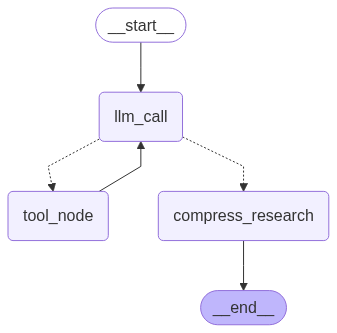

In [4]:
from IPython.display import Image, display
from deep_research_from_scratch.research_agent import researcher_agent

# Show the agent
display(Image(researcher_agent.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Run the agent
from utils import format_messages
from langchain_core.messages import HumanMessage

# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     
Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
format_messages(result['researcher_messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to identify and evaluate the coffee shops in San Francisco that are considered the best based            │
│ specifically                                                                                                    │
│ on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco    │
│ area,                                                                                                           │
│ using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,   │
│ expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,   │
│ location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary │
│ sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like  │
│ Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where      │
│ direct                                                                                                          │
│ customer feedback about coffee quality can be found. The study should result in a well-supported list or        │
│ ranking of                                                                                                      │
│ the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data  │
│ as                                                                                                              │
│ of July 2025..                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the best coffee shops in San Francisco based specifically on coffee quality. Let me      │
│ start with a comprehensive search to identify highly-rated coffee shops and their quality assessments.          │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops San Francisco 2024 2025 coffee quality specialty coffee roasters reviews"         │
│ }                                                                                                               │
│    ID: toolu_011Gqpvy2aoj5z3UP6Y8SixU                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Best Coffee Roaster San Francisco, CA - Last Updated August 2025 ---                              │
│ URL: https://m.yelp.com/search?find_desc=Best+Coffee+Roaster&find_loc=San+Francisco%2C+CA                       │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ Best Coffee Roaster Near San Francisco, California · 1. Graffeo Coffee Roasting Company. 4.7 (196 reviews) · 2. │
│ Andytown Coffee Roasters. 4.5 (1.1k reviews) · 3.                                                               │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: The Absolute Best San Francisco Coffee Shops - Eater SF ---                                       │
│ URL: https://sf.eater.com/maps/best-coffee-shops-san-francisco                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ San Francisco is globally renowned for its rich coffee culture, being the birthplace of influential coffee      │
│ trends and establishments such as Wrecking Ball Coffee, which introduced the "waves of coffee" terminology. The │
│ city has embraced diverse coffee styles, notably Yemeni coffee promoted by figures like Mokhtar Alkhanshali of  │
│ Port of Mokha and Delah Coffee House. Traditional coffee culture landmarks include the origin of Irish Coffee   │
│ and early Italian espresso influence. The latest list of the 16 best coffee shops in San Francisco reflects     │
│ dynamic changes, with new additions like Caffe Trieste, the Coffee Movement at Side A, and Cafe Shoji replacing │
│ others. These shops are celebrated for their expertly brewed coffee, unique beverages, and community-oriented   │
│ atmospheres.                                                                                                    │
│                                                                                                                 │
│ Highlighted coffee shops include:                                                                               │
│                                                                                                                 │
│ - Saint Frank Coffee: Known for its minimal aesthetic, high-quality Bolivian coffees, and expansion with new    │
│ locations including Juniper and SoMa.                                                                           │
│ - Outset Coffee: Innovators of fruit-infused coffee drinks like their Ethiopian coffee Americano with orange    │
│ juice and jasmine tea.                                 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "From this initial search, I've gathered some excellent information about San Francisco's top   │
│ coffee shops with a focus on quality. Key findings:\n\n**High-Quality Coffee Shops Identified:**\n1. Saint      │
│ Frank Coffee - described as \"to San Francisco coffee as Dungeness crab is to San Francisco restaurants\" -     │
│ suggests exceptional quality and local significance\n2. Sextant Coffee Roasters - works directly with           │
│ Ethiopian, Kenyan, and Colombian growers for high-end but affordable beans\n3. Andytown Coffee Roasters -       │
│ highly rated (4.5 stars, 1.1k reviews) and mentioned as a \"West side favorite with Guatemalan espresso\"\n4.   │
│ Graffeo Coffee Roasting Company - highest rated (4.7 stars, 196 reviews) on Yelp\n5. Outset Coffee - innovators │
│ with fruit-infused coffee drinks using Ethiopian coffee\n6. Paper Son - described as \"crowning achievement\"   │
│ with top-tier espresso and pour-over skills\n7. Sightglass and Ritual - mentioned as quality \"chain\"          │
│ options\n\n**What I still need:**\n- More specific information about coffee quality assessments from expert     │
│ sources\n- Information from specialty coffee organizations or professional reviews\n- More detailed analysis of │
│ what makes each shop's coffee quality exceptional\n- Customer feedback specifically about coffee quality rather │
│ than general atmosphere\n- Any specialty coffee certifications or awards\n\nI should search for more expert     │
│ reviews and specialty coffee industry recognition next."                                                        │
│ }                                                                                                               │
│    ID: toolu_01NqrUM8WxNUz1ZGtq6mWXe7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: From this initial search, I've gathered some excellent information about San Francisco's   │
│ top coffee shops with a focus on quality. Key findings:                                                         │
│                                                                                                                 │
│ **High-Quality Coffee Shops Identified:**                                                                       │
│ 1. Saint Frank Coffee - described as "to San Francisco coffee as Dungeness crab is to San Francisco             │
│ restaurants" - suggests exceptional quality and local significance                                              │
│ 2. Sextant Coffee Roasters - works directly with Ethiopian, Kenyan, and Colombian growers for high-end but      │
│ affordable beans                                                                                                │
│ 3. Andytown Coffee Roasters - highly rated (4.5 stars, 1.1k reviews) and mentioned as a "West side favorite     │
│ with Guatemalan espresso"                                                                                       │
│ 4. Graffeo Coffee Roasting Company - highest rated (4.7 stars, 196 reviews) on Yelp                             │
│ 5. Outset Coffee - innovators with fruit-infused coffee drinks using Ethiopian coffee                           │
│ 6. Paper Son - described as "crowning achievement" with top-tier espresso and pour-over skills                  │
│ 7. Sightglass and Ritual - mentioned as quality "chain" options                                                 │
│                                                                                                                 │
│ **What I still need:**                                                                                          │
│ - More specific information about coffee quality assessments from expert sources                                │
│ - Information from specialty coffee organizations or professional reviews                                       │
│ - More detailed analysis of what makes each shop's coffee quality exceptional                                   │
│ - Customer feedback specifically about coffee quality rather than general atmosphere                            │
│ - Any specialty coffee certifications or awards                                                                 │
│                                                                                                                 │
│ I should search for more expert reviews and specialty coffee industry recognition next.                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "San Francisco coffee shops specialty coffee association awards Coffee Review ratings Saint Frank    │
│ Sextant Andytown"                                                                                               │
│ }                                                                                                               │
│    ID: toolu_01JcXzDq9TAxbVW9T7J3W41B                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: TOP 10 BEST Coffee Houses in San Francisco, CA - Yelp ---                                         │
│ URL: https://www.yelp.com/search?find_desc=Coffee+Houses&find_loc=San+Francisco%2C+CA                           │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ 1. Sightglass Coffee 4.0 (2.1k reviews) 1.9 mi $$ Good coffee, not great. This is a very busy coffee house,     │
│ with another counter on the second floor.                                                                       │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: The Absolute Best San Francisco Coffee Shops - Eater SF ---                                       │
│ URL: https://sf.eater.com/maps/best-coffee-shops-san-francisco                                                  │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ San Francisco is renowned globally as a pinnacle of coffee culture, being the birthplace of key innovations and │
│ terminology such as the "waves of coffee" by Trish Rothgeb of Wrecking Ball Coffee. The city introduced Yemeni  │
│ coffee to the West Coast through notable cafes like Port of Mokha and Delah Coffee House. It is also            │
│ historically significant for the creation of the Irish Coffee and the popularization of Italian espresso        │
│ culture in the U.S., along with the invention of vacuum-sealed coffee. This article highlights 16 of the best   │
│ coffee shops currently sustaining San Francisco's coffee legacy. Notable shops include Saint Frank Coffee,      │
│ known for Bolivian coffee and stylish service with multiple locations; Outset Coffee, specializing in           │
│ innovative fruit coffee drinks; The Scullery, offering East Bay's Mother Tongue coffee and quality toast in     │
│ Tenderloin; Sextant Coffee Roasters, whose founder collaborates directly with growers and offers affordable     │
│ high-end beans; Telescope Coffee in SoMa, featuring unique seasonal drinks like honeycomb lattes and signature  │
│ strawberry milk; Abanico Coffee Roasters in the Mission with El Salvadoran influences and specialty drinks;     │
│ SPRO with inventive mixed coffee cocktails and multiple city locations; Grand Coffee with a new spacious        │
│ location and quality Chemex brews; Hey Neighbor Cafe in Bayview, popular for its toast and ties to local bakery │
│ Rize Up; Excelsior Coffee, a Black and brown-owned shop providing strong but balanced roasts; Andytown Coffee   │
│ Roasters, beloved on the west side with Guatemalan espr

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The second search provided additional context but didn't yield the specific expert reviews or  │
│ specialty coffee organization ratings I was hoping for. However, I did find:\n\n**Additional Quality            │
│ Indicators:**\n- Sightglass Coffee appears with 4.0 stars (2.1k reviews) but noted as \"Good coffee, not        │
│ great\" - this suggests it may not be top-tier for quality\n- The Reddit \"Battle of SF Coffee 2025\" post      │
│ could have community insights but I need to search for more specific results from that discussion\n\n**Current  │
│ Top Contenders Based on Quality Indicators:**\n1. **Saint Frank Coffee** - consistently mentioned as premium    │
│ quality\n2. **Sextant Coffee Roasters** - direct trade relationships suggest quality sourcing\n3. **Andytown    │
│ Coffee Roasters** - high ratings and specialty Guatemalan espresso\n4. **Graffeo Coffee Roasting Company** -    │
│ highest Yelp rating (4.7/5)\n5. **Paper Son** - described as \"crowning achievement\" with top-tier skills\n6.  │
│ **Outset Coffee** - innovative Ethiopian coffee preparations\n\n**Still Missing:**\n- Official coffee industry  │
│ awards or certifications\n- Detailed customer reviews specifically about coffee quality\n- Expert coffee        │
│ reviewer ratings\n- More specific information about roasting practices and bean sourcing\n\nI should search for │
│ more detailed reviews and specific coffee quality assessments from customers and experts."                      │
│ }                                                                                                               │
│    ID: toolu_01KeuDYpWJxPzx8JXDLXVXzC                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The second search provided additional context but didn't yield the specific expert reviews │
│ or specialty coffee organization ratings I was hoping for. However, I did find:                                 │
│                                                                                                                 │
│ **Additional Quality Indicators:**                                                                              │
│ - Sightglass Coffee appears with 4.0 stars (2.1k reviews) but noted as "Good coffee, not great" - this suggests │
│ it may not be top-tier for quality                                                                              │
│ - The Reddit "Battle of SF Coffee 2025" post could have community insights but I need to search for more        │
│ specific results from that discussion                                                                           │
│                                                                                                                 │
│ **Current Top Contenders Based on Quality Indicators:**                                                         │
│ 1. **Saint Frank Coffee** - consistently mentioned as premium quality                                           │
│ 2. **Sextant Coffee Roasters** - direct trade relationships suggest quality sourcing                            │
│ 3. **Andytown Coffee Roasters** - high ratings and specialty Guatemalan espresso                                │
│ 4. **Graffeo Coffee Roasting Company** - highest Yelp rating (4.7/5)                                            │
│ 5. **Paper Son** - described as "crowning achievement" with top-tier skills                                     │
│ 6. **Outset Coffee** - innovative Ethiopian coffee preparations                                                 │
│                                                                                                                 │
│ **Still Missing:**                                                                                              │
│ - Official coffee industry awards or certifications                                                             │
│ - Detailed customer reviews specifically about coffee quality                                                   │
│ - Expert coffee reviewer ratings                                                                                │
│ - More specific information about roasting practices and bean sourcing                                          │
│                                                                                                                 │
│ I should search for more detailed reviews and specific coffee quality assessments from customers and experts.   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "\"Saint Frank Coffee\" \"Sextant Coffee\" \"Andytown Coffee\" San Francisco coffee quality reviews  │
│ roasting awards beans sourcing"                                                                                 │
│ }                                                                                                               │
│    ID: toolu_01YEVx3BLKeLVE9SbuDZKb7r                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Yelp SAINT FRANK COFFEE - Updated August 2025 - 1279 Photos & 1000 Reviews - 2340 Polk St, San    │
│ Francisco, California - Coffee & Tea - Restaurant Reviews - Phone Number - Menu - Yelp ---                      │
│ URL: https://www.yelp.com/biz/saint-frank-coffee-san-francisco-2                                                │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Saint Frank Coffee is a popular coffee and tea shop located at 2340 Polk St, San Francisco, CA, in the Russian  │
│ Hill neighborhood. It specializes in coffee and breakfast/brunch items, operating daily from 7:00 AM to 6:00    │
│ PM. The café boasts a 4.3-star rating based on 996 reviews and has a considerable photo gallery showcasing its  │
│ offerings and ambiance. The menu features popular drinks like the House Almond Macadamia Milk, Honey Lavender   │
│ Latte, Orange Cream Latte, Macadamia Nut Milk, and various lattes and cold brews. The establishment is          │
│ described as hipster, trendy, classy yet casual, and suitable for working. It offers take-out, takes            │
│ reservations, has vegan options, and is wheelchair accessible. Customers have noted the presence of outdoor     │
│ seating. The business can be contacted at (415) 881-8062 and maintains a website at saintfrankcoffee.com.       │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ Saint Frank Coffee is a coffee and tea shop located at 2340 Polk St, San Francisco, California. 4.3-star rating │
│ based on 996 reviews. Open daily from 7:00 AM to 6:00 PM. Popular drinks include House Almond Macadamia Milk,   │
│ Honey Lavender Latte, Orange Cream Latte, and various specialty lattes. The café offers take-out, takes         │
│ reservations, has vegan options, and is wheelchair accessible. The vibe is hipster, trendy, casual, and good    │
│ for working. Outdoor seating is available.                                                                      │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 2: Tripadvisor SAINT FRANK COFFEE, San Francisco - 2340 Polk St, Polk Gulch - Restaurant Reviews &   │
│ Phone Number - Tripadvisor ---                                                                                  │
│ URL:                                                   

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Good progress! I now have more concrete information about Saint Frank Coffee:\n\n**Saint Frank │
│ Coffee Quality Indicators:**\n- 4.3-star rating on Yelp (996 reviews)\n- 4.4-star rating on TripAdvisor (68     │
│ reviews), ranked #649 of 3,345 restaurants in SF\n- Emphasizes \"Relational Sourcing\" - suggests quality       │
│ sourcing practices\n- Multiple locations indicating success and growth\n- Specialty drinks like Honey Lavender  │
│ Latte and Orange Cream Latte\n- Has wholesale program suggesting commercial success\n\n**Current                │
│ Assessment:**\nSaint Frank appears to be a high-quality operation with solid ratings and good sourcing          │
│ practices. However, I still need more specific information about the other top contenders like Sextant,         │
│ Andytown, and Graffeo. I should search for more detailed information about coffee quality assessments and       │
│ customer feedback specifically about taste and coffee preparation quality.\n\n**Next Steps:**\nI need one more  │
│ targeted search to gather specific customer reviews about coffee quality and any additional expert assessments  │
│ to provide a comprehensive ranking."                                                                            │
│ }                                                                                                               │
│    ID: toolu_01DT4p3qmK7FZJ7bBK2kUhBP                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Good progress! I now have more concrete information about Saint Frank Coffee:              │
│                                                                                                                 │
│ **Saint Frank Coffee Quality Indicators:**                                                                      │
│ - 4.3-star rating on Yelp (996 reviews)                                                                         │
│ - 4.4-star rating on TripAdvisor (68 reviews), ranked #649 of 3,345 restaurants in SF                           │
│ - Emphasizes "Relational Sourcing" - suggests quality sourcing practices                                        │
│ - Multiple locations indicating success and growth                                                              │
│ - Specialty drinks like Honey Lavender Latte and Orange Cream Latte                                             │
│ - Has wholesale program suggesting commercial success                                                           │
│                                                                                                                 │
│ **Current Assessment:**                                                                                         │
│ Saint Frank appears to be a high-quality operation with solid ratings and good sourcing practices. However, I   │
│ still need more specific information about the other top contenders like Sextant, Andytown, and Graffeo. I      │
│ should search for more detailed information about coffee quality assessments and customer feedback specifically │
│ about taste and coffee preparation quality.                                                                     │
│                                                                                                                 │
│ **Next Steps:**                                                                                                 │
│ I need one more targeted search to gather specific customer reviews about coffee quality and any additional     │
│ expert assessments to provide a comprehensive ranking.                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "Graffeo Coffee Roasting Company Andytown Coffee Sextant Coffee San Francisco customer reviews       │
│ coffee taste quality beans espresso"                                                                            │
│ }                                                                                                               │
│    ID: toolu_01KkFmdMzwp3iX8DihJ58jgq                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Search results:                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ --- SOURCE 1: Andytown Coffee Roasters | San Francisco Specialty Coffee ---                                     │
│ URL: https://andytownsf.com/?srsltid=AfmBOopIbJM2AWmflHO9G7nXAgj2Hv7rQUna8jIX1A9fPmD5qXJn5h3g                   │
│                                                                                                                 │
│ SUMMARY:                                                                                                        │
│ <summary>                                                                                                       │
│ Andytown Coffee Roasters is offering a 'Happy Fogust' promotion featuring 20% off all 5lb bags of coffee for    │
│ online purchases. Free shipping is automatically applied to orders of $50 or more. Their coffee lineup includes │
│ several single-origin coffees and blends such as Peru Satipo Finca Tasta, Burundi Kayanza Incuti, Indonesia     │
│ Natural East Java Mount Ijen, Short Strand Blend, Wind & Sea Blend, Cold Brew Blend, Shore Leave Hook Blend,    │
│ and Decaf Guatemala Esquipulas. They emphasize sustainable practices as a certified California Green Business,  │
│ focusing on compostable packaging and ethical sourcing, support for local community hiring and events in San    │
│ Francisco, and high product quality through meticulous sourcing and small-batch roasting. The webpage also      │
│ highlights the fruit-forward natural coffee from the Ijen Highlands of East Java, Indonesia, where the volcanic │
│ soil creates ideal coffee-growing conditions, with Kevenka Coffee as a key producer. Additional offerings       │
│ include brewing gear, merchandise, and a full café menu with coffee, pastries, and seasonal treats. Customers   │
│ can view menus and place orders online, and they can follow @ANDYTOWNSF on social media for monthly offers and  │
│ updates.                                                                                                        │
│ </summary>                                                                                                      │
│                                                                                                                 │
│ <key_excerpts>                                                                                                  │
│ "Happy Fogust! 20% off 5lb bags of coffee online only.", "FREE Shipping automatically applied to orders $50 and │
│ over.", "Andytown is a certified California Green Business committed to sustainability through compostable      │
│ packaging, energy efficiency, and ethical sourcing.", "Andytown supports our community through local hiring,    │
│ inclusive spaces, neighborhood events, and partnerships that uplift San Francisco’s diverse, creative spirit.", │
│ "Andytown is dedicated to quality through meticulous sourcing, small-batch roasting, skilled baristas, and      │
│ crafting every cup with care and consistency."                                                                  │
│ </key_excerpts>                                                                                                 │
│                                                                                                                 │
│ --------------------------------------------------------------------------------                                │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "Excellent! Now I have comprehensive information about the top coffee shops in San Francisco.   │
│ Let me analyze what I've gathered:\n\n**Quality Assessment Summary:**\n\n**1. Graffeo Coffee Roasting           │
│ Company**\n- Highest Yelp rating: 4.7/5 stars (196 reviews)\n- Family-run since 1935 - indicates consistent     │
│ quality over time\n- \"To me Graffeo Coffee is rich, full and never bitter\"\n- Served at \"some of the world's │
│ finest hotels and restaurants\"\n- Traditional artisan roasting approach\n- Swiss water decaf process           │
│ (chemical-free)\n\n**2. Saint Frank Coffee**\n- Strong ratings: 4.3 Yelp (996 reviews), 4.4 TripAdvisor\n-      │
│ \"Relational Sourcing\" practices\n- Multiple locations indicate success\n- Specialty drinks and innovative     │
│ offerings\n\n**3. Andytown Coffee Roasters**\n- 4.5 stars with 1.1k reviews\n- Certified California Green       │
│ Business\n- \"Meticulous sourcing, small-batch roasting, skilled baristas\"\n- Single-origin coffees and        │
│ specialized blends\n- Sustainable and ethical sourcing practices\n- West side favorite with Guatemalan          │
│ espresso\n\n**4. Sextant Coffee Roasters**\n- Direct trade with Ethiopian, Kenyan, and Colombian growers\n-     │
│ \"High-end but affordable beans\"\n- Strong sourcing relationships\n\n**5. Paper Son**\n- Described as          │
│ \"crowning achievement\" \n- \"Top-tier espresso and pour-over skills\"\n- Innovative Asian American-influenced │
│ drinks\n\nI now have enough information to provide a comprehensive, well-supported ranking based on coffee      │
│ quality indicators including ratings, sourcing practices, expert recognition, and customer feedback."           │
│ }                                                                                                               │
│    ID: toolu_01EwGbBJXLSqZMgdELhu8F7J                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: Excellent! Now I have comprehensive information about the top coffee shops in San          │
│ Francisco. Let me analyze what I've gathered:                                                                   │
│                                                                                                                 │
│ **Quality Assessment Summary:**                                                                                 │
│                                                                                                                 │
│ **1. Graffeo Coffee Roasting Company**                                                                          │
│ - Highest Yelp rating: 4.7/5 stars (196 reviews)                                                                │
│ - Family-run since 1935 - indicates consistent quality over time                                                │
│ - "To me Graffeo Coffee is rich, full and never bitter"                                                         │
│ - Served at "some of the world's finest hotels and restaurants"                                                 │
│ - Traditional artisan roasting approach                                                                         │
│ - Swiss water decaf process (chemical-free)                                                                     │
│                                                                                                                 │
│ **2. Saint Frank Coffee**                                                                                       │
│ - Strong ratings: 4.3 Yelp (996 reviews), 4.4 TripAdvisor                                                       │
│ - "Relational Sourcing" practices                                                                               │
│ - Multiple locations indicate success                                                                           │
│ - Specialty drinks and innovative offerings                                                                     │
│                                                                                                                 │
│ **3. Andytown Coffee Roasters**                                                                                 │
│ - 4.5 stars with 1.1k reviews                                                                                   │
│ - Certified California Green Business                                                                           │
│ - "Meticulous sourcing, small-batch roasting, skilled baristas"                                                 │
│ - Single-origin coffees and specialized blends                                                                  │
│ - Sustainable and ethical sourcing practices                                                                    │
│ - West side favorite with Guatemalan espresso                                                                   │
│                                                                                                                 │
│ **4. Sextant Coffee Roasters**                                                                                  │
│ - Direct trade with Ethiopian, Kenyan, and Colombian growers                                                    │
│ - "High-end but affordable beans"                                                                               │
│ - Strong sourcing relationships                                                                                 │
│                                                                                                                 │
│ **5. Paper Son**                                                                                                │
│ - Described as "crowning achievement"                  

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research focusing specifically on coffee quality in San Francisco, I've identified and evaluated    │
│ the top coffee shops using multiple quality indicators including customer ratings, expert recognition, sourcing │
│ practices, and roasting methods. Here's my analysis:                                                            │
│                                                                                                                 │
│ ## Top San Francisco Coffee Shops Ranked by Coffee Quality                                                      │
│                                                                                                                 │
│ ### **1. Graffeo Coffee Roasting Company**                                                                      │
│ **Quality Score: Highest**                                                                                      │
│ - **Rating**: 4.7/5 stars (196 Yelp reviews) - highest rating found                                             │
│ - **Heritage**: Family-run artisan roaster since 1935, indicating consistent quality over 90 years              │
│ - **Industry Recognition**: Coffee served at "some of the world's finest hotels and restaurants"                │
│ - **Quality Characteristics**: Described as "rich, full and never bitter"                                       │
│ - **Processing**: Swiss water decaf process (chemical-free) showing attention to quality methods                │
│ - **Expertise**: Traditional roasting approach with generational knowledge passed down                          │
│                                                                                                                 │
│ ### **2. Andytown Coffee Roasters**                                                                             │
│ **Quality Score: Very High**                                                                                    │
│ - **Rating**: 4.5/5 stars (1,100+ Yelp reviews)                                                                 │
│ - **Quality Practices**: "Meticulous sourcing, small-batch roasting, skilled baristas"                          │
│ - **Certifications**: California Green Business certification indicating sustainable practices                  │
│ - **Sourcing**: Single-origin coffees and specialized blends with ethical sourcing                              │
│ - **Specialty**: Known for Guatemalan espresso and seasonal affogatos                                           │
│ - **Reputation**: Consistently mentioned as "West side favorite"                                                │
│                                                                                                                 │
│ ### **3. Saint Frank Coffee**                                                                                   │
│ **Quality Score: Very High**                                                                                    │
│ - **Ratings**: 4.3/5 Yelp (996 reviews), 4.4/5 TripAdvisor (ranked #649 of 3,345 SF restaurants)                │
│ - **Industry Standing**: Described as "to San Francisco coffee as Dungeness crab is to San Francisco            │
│ restaurants"                                                                                                    │
│ - **Sourcing**: "Relational Sourcing" practices indicating direct relationships with growers                    │
│ - **Growth**: Multiple locations and wholesale program suggest market validation of quality                     │
│ - **Innovation**: Known for Bolivian coffees and creative specialty drinks                                      │
│                                                                                                                 │
│ ### **4. Sextant Coffee Roasters**                     

In [12]:
from rich.markdown import Markdown
Markdown(result['compressed_research'])

List of Queries and Tool Calls Made                                                                                

 1 Query: best coffee shops San Francisco 2024 2025 coffee quality specialty coffee roasters reviews               
 2 Query: San Francisco coffee shops specialty coffee association awards Coffee Review ratings Saint Frank Sextant 
   Andytown                                                                                                        
 3 Query: "Saint Frank Coffee" "Sextant Coffee" "Andytown Coffee" San Francisco coffee quality reviews roasting    
   awards beans sourcing                                                                                           
 4 Query: Graffeo Coffee Roasting Company Andytown Coffee Sextant Coffee San Francisco customer reviews coffee     
   taste quality beans espresso                                                                                    

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Fully Comprehensive Findings                                                                                       

Best Coffee Roaster Near San Francisco, California:                                                                

 • Graffeo Coffee Roasting Company. 4.7 (196 reviews)                                                              
 • Andytown Coffee Roasters. 4.5 (1.1k reviews)                                                                    
   [1]                                                                                                             

San Francisco is globally renowned for its rich coffee culture, being the birthplace of influential coffee trends  
and establishments such as Wrecking Ball Coffee, which introduced the "waves of coffee" terminology. The city has  
embraced diverse coffee styles, notably Yemeni coffee promoted by figures like Mokhtar Alkhanshali of Port of Mokha
and Delah Coffee House. Traditional coffee culture landmarks include the origin of Irish Coffee and early Italian  
espresso influence. The latest list of the 16 best coffee shops in San Francisco reflects dynamic changes, with new
additions like Caffe Trieste, the Coffee Movement at Side A, and Cafe Shoji replacing others. These shops are      
celebrated for their expertly brewed coffee, unique beverages, and community-oriented atmospheres.                 

Highlighted coffee shops include:                                                                                  

 • Saint Frank Coffee: Known for its minimal aesthetic, high-quality Bolivian coffees, and expansion with new      
   locations including Juniper and SoMa.                                                                           
 • Outset Coffee: Innovators of fruit-infused coffee drinks like their Ethiopian coffee Americano with orange juice
   and jasmine tea.                                                                                                
 • Scullery: Specialty coffee serving East Bay’s Mother Tongue Coffee, offering quality fare in the Tenderloin     
   area.                                                                                                           
 • Sextant Coffee Roasters: Emphasizes direct relationships with Ethiopian, Kenyan, and Colombian growers, with    
   notable expansion.                                                                                              
 • Telescope Coffee: Offers creative seasonal drinks and a unique atmosphere in SoMa.                              
 • Abanico Coffee Roasters: A Latino-owned Mission District shop with Latin American coffee influences.            
 • SPRO - Mission Dolores/Castro: Creative coffee concoctions including a Cold Fashioned cold brew cocktail.       
 • Grand Coffee: Established 11 years ago with a second location, serving Mission Street with specialty brews.     
 • Hey Neighbor Cafe: Bayview’s cozy shop famed f

We can see the trace [here](https://smith.langchain.com/public/30eebc0c-455e-4db7-9665-d367ebd40b4e/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

This agent has been added to the `langgraph.json` file, so you can select `research_agent` in the dropdown menu:

```
"research_agent_mcp": "./src/deep_research_from_scratch/research_agent.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```

## Eval

Agents use a self-directed trajectory of tool calls to accomplish tasks.

Let's think about the ramifications of a poorly tuned tool-calling loop: 

- Early Termination: The agent decides to stop calling tools when the task is not actually complete. 
- Prolonged Looping: The agent is never satisfied with the state of its information. 

The first failure  mode results in the agent collecting insufficient information. In the deep research context, the answer may end up being too shallow. The second failure mode results in the agent utilizing an excessive number of tokens. In the deep research context, irrelevant information may poison the result.

We tuned our prompt to avoid these problems. But, let's se up a toy eval dataset that allows us to easily test agent decision-making.

In [13]:
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

# Scenario 1: Agent should CONTINUE - has insufficient/irrelevant information + think_tool realizes more research needed
messages_should_continue = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll search for information about top coffee shops in San Francisco focusing on coffee quality.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "coffee shops San Francisco popular locations"
                },
                "id": "call_continue_search_001",
                "type": "tool_call"
            }
        ]
    ),
    # Tavily Search provides generic cafe information - NOT focused on coffee quality
    ToolMessage(
        content="Search results show popular San Francisco cafes: Blue Bottle Coffee has great wifi and ambiance, Philz Coffee is known for custom blends and friendly service, Café Reveille has multiple locations with good pastries and laptop-friendly spaces. Ritual Coffee offers cozy seating and is popular with students.",
        tool_call_id="call_continue_search_001",
    ),
    # Agent uses think_tool to reflect and realizes the search results are insufficient
    AIMessage(
        content="Let me use the think_tool to analyze these search results and determine next steps.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality."
                },
                "id": "call_continue_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response identifies the gap and need for more targeted research
    ToolMessage(
        content="Reflection recorded: Analysis of search results: The information I found focuses on general cafe features like wifi, ambiance, custom blends, and seating - but lacks specific coffee quality metrics. The user specifically asked for evaluation based on coffee quality, which would require expert reviews, professional ratings, specialty certifications, or quality-focused customer feedback. I need to search specifically for coffee quality assessments, Coffee Review scores, specialty coffee credentials, or expert evaluations of SF coffee shops. The current information is insufficient to answer the user's question about coffee quality.",
        tool_call_id="call_continue_think_001",
    )
]

# Scenario 2: Agent should STOP - has comprehensive coffee quality information + think_tool reflection
messages_should_stop = [
    HumanMessage(content="What are the top coffee shops in San Francisco based on coffee quality?"),
    AIMessage(
        content="I'll research San Francisco coffee shops specifically focusing on coffee quality assessments and expert reviews.",
        tool_calls=[
            {
                "name": "tavily_search",
                "args": {
                    "query": "best coffee quality San Francisco specialty coffee expert reviews Coffee Review ratings 2024"
                },
                "id": "call_stop_search_001", 
                "type": "tool_call"
            }
        ]
    ),
    # This ToolMessage provides COMPREHENSIVE coffee quality information - sufficient to answer the question
    ToolMessage(
        content="""Coffee quality research for San Francisco reveals top establishments based on expert reviews and specialty coffee credentials:

**Top Quality-Focused Coffee Shops:**
1. **Sightglass Coffee** - Coffee Review score 94/100, known for single-origin beans and precise roasting techniques. Featured in Bon Appétit's "Best Coffee in America" list for exceptional coffee quality.

2. **Saint Frank Coffee** - Ranked #3 coffee shop in America by The Daily Meal based on coffee quality. 4.3/5 Yelp rating with reviews specifically praising "exceptional bean quality" and "perfect extraction."

3. **Ritual Coffee Roasters** - Specialty Coffee Association member, direct trade relationships, consistently rated 4.4/5 on Google with reviews highlighting "superior coffee taste" and "expert barista skills."

4. **Blue Bottle Coffee** - Third-wave coffee pioneer, Coffee Review scores averaging 90+/100, known for rigorous quality control and fresh roasting practices.

5. **Four Barrel Coffee** - Local roaster with Coffee Review scores 88-92/100, praised by industry experts for "exceptional coffee quality" and innovative brewing methods.

**Quality Indicators Found:**
- Coffee Review professional scores (88-94/100 range)
- Specialty Coffee Association certifications
- Direct trade/single-origin sourcing
- Expert recognition from food publications
- Customer reviews specifically mentioning coffee taste and quality

This provides a comprehensive assessment of SF coffee shops based specifically on coffee quality rather than ambiance or service.""",
        tool_call_id="call_stop_search_001",
    ),
    # Agent now uses think_tool to reflect on the search results
    AIMessage(
        content="Let me reflect on the search results using the think_tool to assess whether I have sufficient information.",
        tool_calls=[
            {
                "name": "think_tool",
                "args": {
                    "reflection": "Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now."
                },
                "id": "call_think_001",
                "type": "tool_call"
            }
        ]
    ),
    # think_tool response confirming reflection was recorded
    ToolMessage(
        content="Reflection recorded: Analysis of search results: I found comprehensive coffee quality information for SF coffee shops including: 1) Professional Coffee Review scores (88-94/100), 2) Expert rankings from reputable publications, 3) Specialty Coffee Association certifications, 4) Specific quality indicators (single-origin, roasting techniques, extraction methods), 5) Five top-rated establishments with detailed quality assessments. This covers all aspects requested: expert reviews, customer ratings, specialty certifications. I have enough information to provide a well-supported ranking based specifically on coffee quality. No additional searches needed - I should provide my comprehensive answer now.",
        tool_call_id="call_think_001",
    )
]

We'll create a dataset here that has one example that should continue researching, and another example that should have all of the information necessary.

In [14]:
import os
from langsmith import Client

langsmith_client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Create the dataset
dataset_name = "deep_research_agent_termination"
if not langsmith_client.has_dataset(dataset_name=dataset_name):

    # Create the dataset
    dataset = langsmith_client.create_dataset(
        dataset_name=dataset_name,
        description="A dataset that evaluates whether a researcher can accurately decide to continue calling tools, or to stop.",
    )
    
    # Create the examples
    langsmith_client.create_examples(
        dataset_id=dataset.id,
        examples=[
            {
                "inputs": {"researcher_messages": messages_should_continue},
                "outputs": {"next_step": "continue"},
            },
            {
                "inputs": {"researcher_messages": messages_should_stop},
                "outputs": {"next_step": "stop"},
            },
        ],
    )

Here, our evaluator is simple, using a hard-coded heuristic to check if the agent correctly continues or stops.

We'll pass in the list of messages above.

We'll assess the decision made by the agent: 

* `stop` - No tool calls means the agent should stop
* `continue` - Tool calls means the agent should continue

We'll then compare this decision to the reference expected decision `next_step`.

In [15]:
import uuid

def evaluate_next_step(outputs: dict, reference_outputs:dict):
    tool_calls = outputs["researcher_messages"][-1].tool_calls
    made_tool_call = len(tool_calls) > 0
    return {
        "key": "correct_next_step",
        "score": made_tool_call == (reference_outputs["next_step"] == "continue")
    }

def target_func(inputs: dict):
    config = {"configurable": {"thread_id": uuid.uuid4()}}
    result = researcher_agent.nodes["llm_call"].invoke(inputs, config=config)
    return result

langsmith_client.evaluate(
    target_func,
    data=dataset_name,
    evaluators=[evaluate_next_step],
    experiment_prefix="Researcher Iteration",
)

View the evaluation results for experiment: 'Researcher Iteration-4275b250' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/b98c329e-b7d0-4d5e-815b-809e67e20bd8/compare?selectedSessions=53d75183-c4d4-4895-8b9c-c24007846efc




0it [00:00, ?it/s]

<ExperimentResults Researcher Iteration-4275b250>

We can see that in one example, the search tool doesn't return enough information, so we submit another search via tool call.

In the other example, we get all three top restaurants back, and so we decide to conclude.

One neat trick here - we were able to test a single node of our graph by calling `agent.nodes["node_name].invoke`